In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [2]:
# read dataset
df=pd.read_excel("nutrient-file-release2-jan22.xlsx", sheet_name='All solids & liquids per 100g', engine='openpyxl')

## Data Preprocessing

In [3]:
### DATA PREPROCESSING
# Compute the percentage of missing data
missing_values = df.isna().sum()
total_cells = df.size
percentage_missing = (missing_values.sum() / total_cells) * 100
print(f"The percentage of missing data is: {percentage_missing:.2f}%")

# drop columns with less than 50% non-null values
df = df[df['Classification'].astype(str).str.startswith(("15", "17", "18", "19", "20"), na=False)]
df = df.dropna(axis=1, thresh=len(df)*0.5)

# Fill missing values with mean imputation
df = df.fillna(df.mean(numeric_only=True))

The percentage of missing data is: 60.52%


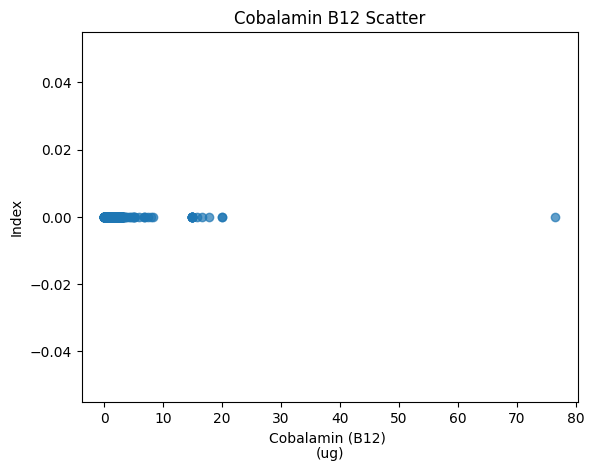

<Figure size 640x480 with 0 Axes>

In [4]:
# create a scatter plot with one feature just to visualise if there are any outlier for the target feature
plt.scatter(df['Cobalamin (B12) \n(ug)'], [0]*len(df), alpha=0.7)
plt.xlabel('Cobalamin (B12) \n(ug)')
plt.ylabel('Index')
plt.title('Cobalamin B12 Scatter')
plt.show()
plt.savefig('outlier.png')

# Remove outlier
df = df.sort_values(by='Cobalamin (B12) \n(ug)',ascending=False)
df = df[1:]

## Feature Selection

In [5]:
### FEATURE SELECTION

## Split traning-test set
# drop first 3 classification columns and Vitamin B12 columns
X = df.drop('Cobalamin (B12) \n(ug)', axis=1).iloc[:, 3:] 
y = df['Cobalamin (B12) \n(ug)']
X_train, X_test, y_train, y_test = train_test_split(X, y , train_size=0.7, random_state=237)
# concat x_test and y_test to a dataframe to generate correlation matrix
test_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

In [7]:
## Multicollinearity
# remove high colinearity variables
CORR_THRESHOLD = 0.7

independence = test_df.drop(['Cobalamin (B12) \n(ug)'], axis=1)
correlation = independence.corr()
indepen_col = independence.columns

drop_hc = []
for feature1 in indepen_col:
        for feature2 in indepen_col:
            if feature1 != feature2 and feature2 not in drop_hc and correlation[feature1][feature2] > CORR_THRESHOLD:
                drop_hc.append(feature1)

test_df = test_df.drop(drop_hc, axis=1)

Top 5 highly correlated features with target variable:
 C22:5w3 (%T)          0.466240
Iron (Fe) \n(mg)      0.416665
Iodine (I) \n(ug)     0.403905
Copper (Cu) \n(mg)    0.389662
C17 (%T)              0.357141
Name: Cobalamin (B12) \n(ug), dtype: float64


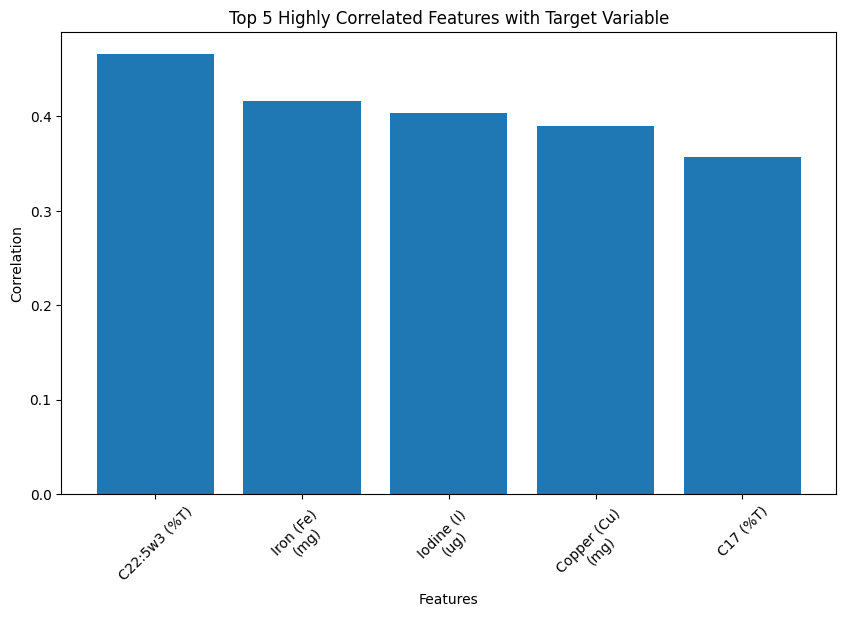

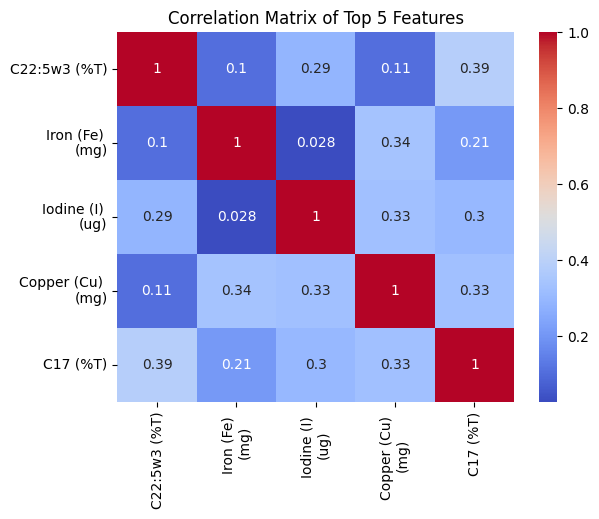

In [8]:
## Ranking-based feature selection
# Compute the correlation matrix
corr_matrix = test_df.corr()
target = [c for c in  df.columns if 'Cobalamin (B12) \n(ug)' in c][0]

# Select the features with the highest correlation coefficients
corr_with_target = corr_matrix[target].sort_values(ascending=False)
top_features = corr_with_target[1:6]  # exclude the target variable itself
print('Top 5 highly correlated features with target variable:\n', top_features)

# Plot the correlation values
plt.figure(figsize=(10, 6))
plt.bar(top_features.index, top_features.values)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Top 5 Highly Correlated Features with Target Variable')
plt.xticks(rotation=45)
plt.savefig('Features.png',dpi=900)
plt.show()

# Create a heatmap plot of the correlation matrix
top_corr_matrix=test_df[top_features.keys()].corr()
sns.heatmap(top_corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix of Top 5 Features')
plt.savefig('Correlation Matrix.png')
plt.show()

array([[<Axes: xlabel='C22:5w3 (%T)', ylabel='C22:5w3 (%T)'>,
        <Axes: xlabel='Iron (Fe) \n(mg)', ylabel='C22:5w3 (%T)'>,
        <Axes: xlabel='Iodine (I) \n(ug)', ylabel='C22:5w3 (%T)'>,
        <Axes: xlabel='Copper (Cu) \n(mg)', ylabel='C22:5w3 (%T)'>,
        <Axes: xlabel='C17 (%T)', ylabel='C22:5w3 (%T)'>],
       [<Axes: xlabel='C22:5w3 (%T)', ylabel='Iron (Fe) \n(mg)'>,
        <Axes: xlabel='Iron (Fe) \n(mg)', ylabel='Iron (Fe) \n(mg)'>,
        <Axes: xlabel='Iodine (I) \n(ug)', ylabel='Iron (Fe) \n(mg)'>,
        <Axes: xlabel='Copper (Cu) \n(mg)', ylabel='Iron (Fe) \n(mg)'>,
        <Axes: xlabel='C17 (%T)', ylabel='Iron (Fe) \n(mg)'>],
       [<Axes: xlabel='C22:5w3 (%T)', ylabel='Iodine (I) \n(ug)'>,
        <Axes: xlabel='Iron (Fe) \n(mg)', ylabel='Iodine (I) \n(ug)'>,
        <Axes: xlabel='Iodine (I) \n(ug)', ylabel='Iodine (I) \n(ug)'>,
        <Axes: xlabel='Copper (Cu) \n(mg)', ylabel='Iodine (I) \n(ug)'>,
        <Axes: xlabel='C17 (%T)', ylabel='Iodine (I) 

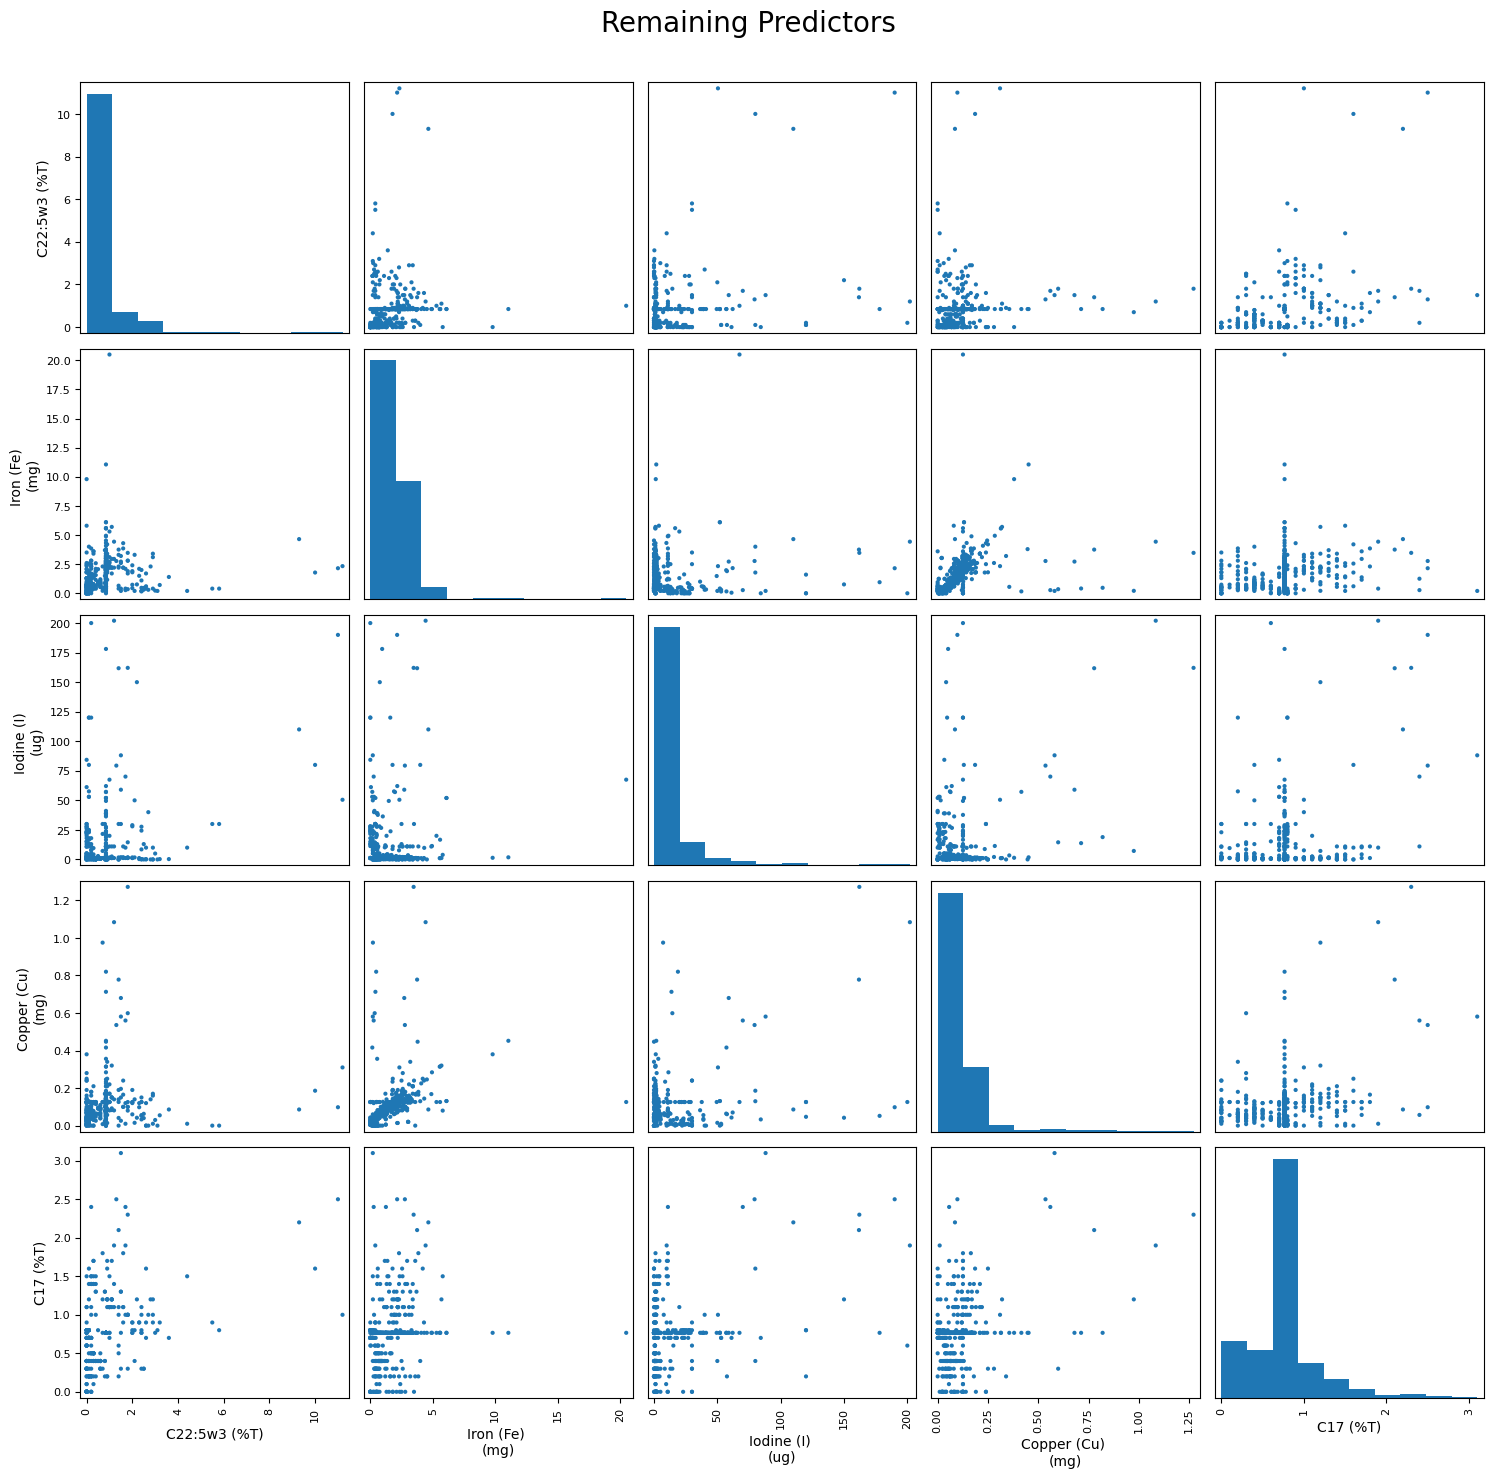

In [9]:
## Visualize remaining predictors
# Select remaining features in X_train and X_test
X_train = test_df[top_features.keys()]
X_test = X_test[top_features.keys()]
# Scatter plot matrix between remaining predictors
corr_matrix_scatter = scatter_matrix(X_train, alpha = 1, figsize = (15, 15), diagonal = 'hist')
plt.suptitle("Remaining Predictors", size=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
display(corr_matrix_scatter)

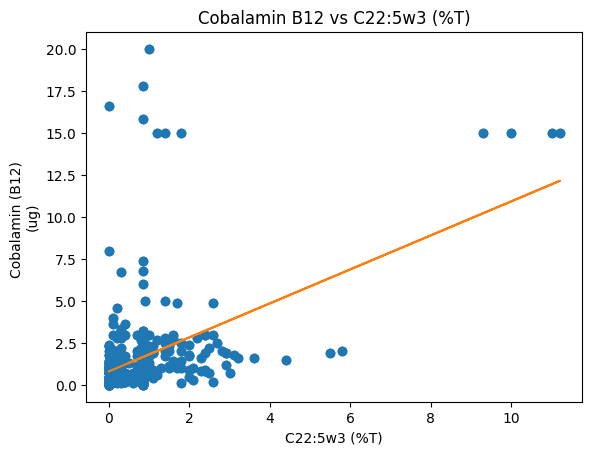

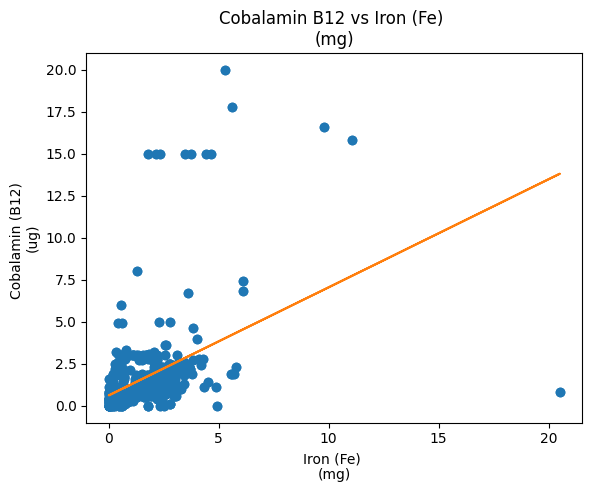

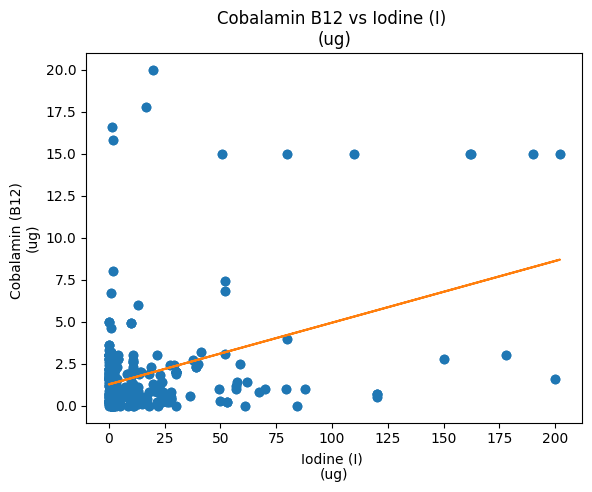

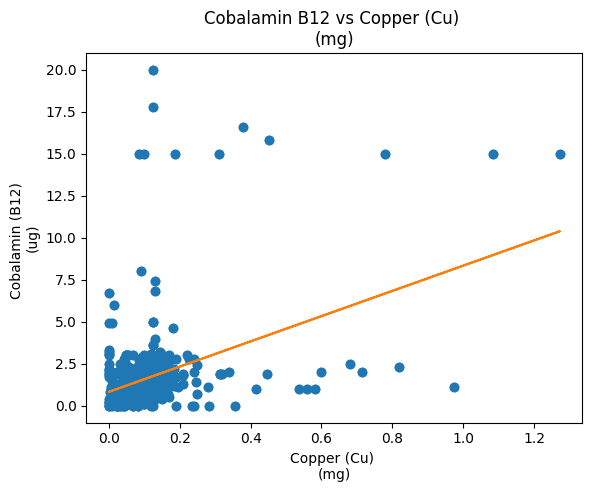

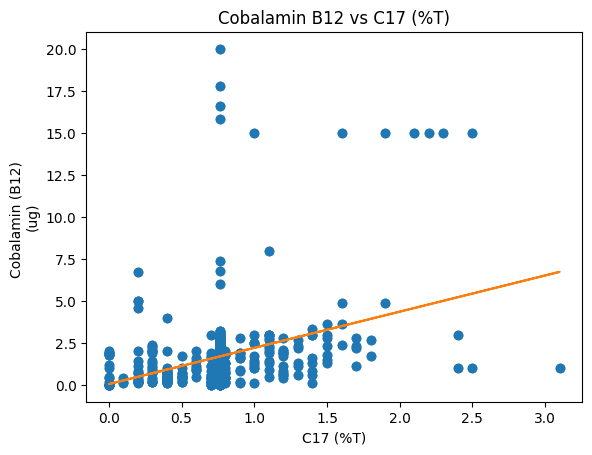

In [10]:
### ANALYSIS
## Preliminary analysis
# Scatterplot between Vitamin B12 and chosen features
chosen_features = X_train.columns
scatter_num = 0

for feature in chosen_features:
    plt.scatter(test_df[feature], test_df['Cobalamin (B12) \n(ug)'])
    scatter_num += 1

    x2 = test_df[feature]
    y2 = test_df['Cobalamin (B12) \n(ug)']
    
    m2, b2 = np.polyfit(x2, y2, 1)
    plt.plot(x2, y2, 'o')
    plt.plot(x2, m2*x2 + b2)
    
    # Add label
    plt.xlabel(feature)
    plt.ylabel('Cobalamin (B12) \n(ug)')
    plt.title(f'Cobalamin B12 vs {feature}')
    plt.savefig(f'{scatter_num}_Scattter.png',dpi=900) 
    plt.show()

## Model Building

In [11]:
### MODELS

## Model 1
# Fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions on the train set and test set
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

In [12]:
## Evaluate model 1 performance

# Compute R-squared coefficient
print('R^2 score:', r2_score(y_test, y_pred))
# Compute root mean squared error (RMSE) between the predicted and actual target variable values
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Define root mean squared error (RMSE) scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform 10-fold cross validation
rmse_scorer = make_scorer(rmse, greater_is_better=False)
X = X[top_features.keys()]
scores = cross_val_score(lr, X, y, cv=10, scoring=rmse_scorer)

# The scores are negated due to the design of cross_val_score (it assumes that higher score is better).
# Therefore, you need to negate the scores to get the actual RMSE.
rmse_scores = -scores

# Print mean RMSE score
print(f'Mean RMSE: {np.mean(rmse_scores)}')

R^2 score: 0.49746805972357344
RMSE: 1.551313091287066
Mean RMSE: 1.7694649457933882


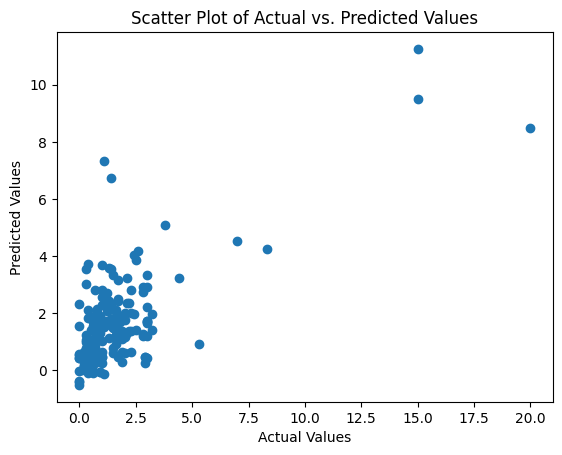

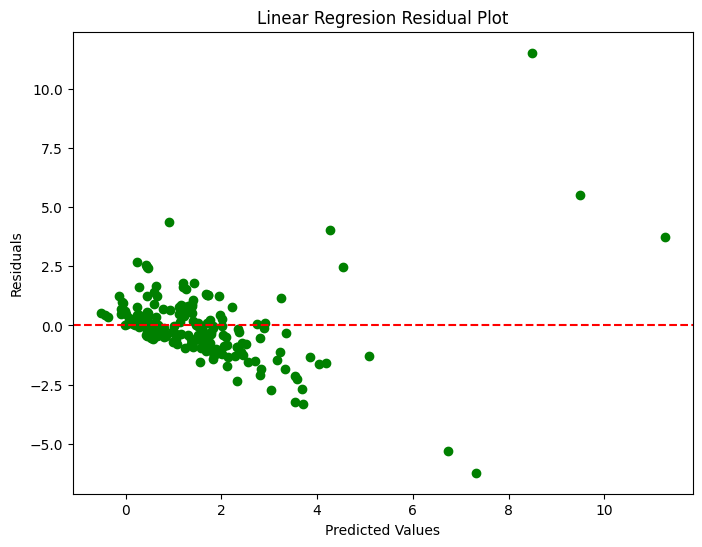

In [13]:
# Create scatter plot between actual and predicted value
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.savefig('Scatter.png',dpi=900)
plt.show()

# Analyticals for single-fold 
# Calculate residuals
residuals = y_test - y_pred
# Plot residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='g')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Linear Regresion Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('Residuals.png',dpi=900)
plt.show()

In [14]:
## Model 2
rf_model = RandomForestRegressor(random_state=1)

# Fit the model
rf_model.fit(X_train, y_train)
rf_val_preds = rf_model.predict(X_test)

## Evaluate model 2 performance
# Print out validation metrics
print("Validation R^2 for Random Forest Model: {}".format(r2_score(y_test, rf_val_preds)))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_val_preds)))

# Perform k-fold cross validation calculating rmse score
n = 10
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, X, y, cv=n, scoring=rmse_scorer)

# The scores are negated due to the design of cross_val_score
# Therefore, you need to negate the scores to get the actual RMSE.
rf_rmse_scores = -rf_scores

# Print mean RMSE score
print(f'Mean RMSE: {np.mean(rf_rmse_scores)}')

Validation R^2 for Random Forest Model: 0.45074103740665006
RMSE: 1.6218332449955974
Mean RMSE: 1.7829485787762795
